<a href="https://colab.research.google.com/github/AkhilVinayakp/HAR_LSTM_CNN/blob/main/Lstm_Cnn_model_inp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
april 23  test final
'''

'\napril 23  test final\n'

In [ ]:
!python --version

Python 3.7.10


In [ ]:
!cat /proc/meminfo

In [ ]:
!nvidia-smi

Mon May  3 01:53:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras

In [ ]:
keras.__version__

'2.4.0'

In [ ]:
%cd /content/drive/My\ Drive/datasets 
%pwd

/content/drive/My Drive/datasets


'/content/drive/My Drive/datasets'

In [ ]:

df =  pd.read_csv('int_norm.csv')

In [ ]:
df.shape

(1098204, 6)

In [ ]:
def create_windowed_dataset(series, window_size,shift_size, batch_size,shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size , shift = shift_size, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.map(lambda window: ( window[:,1:], tf.one_hot(tf.cast(window[window_size -1 , 0], tf.int64), depth=6) ))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
df.drop('timestamp', axis = 1, inplace=True)

In [ ]:
df.activity = df.activity.astype('category').cat.codes
df.activity = df.activity.astype('int64')

In [ ]:
train = df[df['user'] < 31 ]
test = df[df['user'] > 30]

In [ ]:
train.drop('user', axis = 1, inplace=True)
test.drop('user', axis = 1, inplace=True)
train.reset_index(drop = True, inplace = True)
test.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print(train.shape)
print(test.shape)

(898361, 4)
(199843, 4)


In [ ]:
print(train.shape)
print(test.shape)

(898361, 4)
(199843, 4)


In [ ]:
train.head()

,activity,x-axis,y-axis,z-axis
0,5,0.058149,0.996847,-0.053996
1,5,-0.000000,0.998427,-0.056061
2,5,-0.023448,0.997247,-0.070345
3,5,0.014845,0.998642,-0.049932
4,5,0.014737,0.998072,-0.060286


In [ ]:
test.head()

,activity,x-axis,y-axis,z-axis
0,1,-0.054655,0.997718,0.039652
1,1,0.405338,0.910910,0.077102
2,1,0.410782,0.911708,-0.006846
3,1,-0.032685,0.986373,0.161248
4,1,-0.083804,0.856341,0.509566


In [ ]:
# creating test set
def create_test_windowed(series, window_size = 128):
  test = tf.data.Dataset.from_tensor_slices(series)
  test = test.window(window_size,shift = 64, drop_remainder = True)
  test = test.flat_map(lambda window: window.batch(window_size))
  test = test.map(lambda window: (window[:,1:], tf.one_hot(tf.cast(window[window_size -1 , 0], tf.int64), depth=6)))
  return test

In [ ]:
test_win = create_test_windowed(test)   # test data set for evaluation

In [ ]:
test_data = list(test_win.as_numpy_iterator())

In [ ]:
test_f = []
test_l = []
for i in test_data:
  test_f.append(i[0])
  test_l.append(i[1])

In [ ]:
test_f = np.array(test_f)

In [ ]:
test_f.shape

(3121, 128, 3)

In [ ]:
test_f.shape

(3121, 128, 3)

In [ ]:

test_l = np.array(test_l)

In [ ]:
test_l.shape

(3121, 6)

In [ ]:
x_val = test_f[:200]
y_val = test_l[:200]
print(x_val.shape)
print(y_val.shape)

(200, 128, 3)
(200, 6)


In [ ]:
train_windowed = create_windowed_dataset(train, 128, 64, 192, 128)

Run the model According to choice
1.Model available in the paper
2.Bidiractional model

In [ ]:
# # adding globel average pooling to the model
# codding lstm layers and cnn
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,
                      input_shape=[128, 3]),
  tf.keras.layers.RNN(tf.keras.layers.LSTMCell(32), return_sequences=True),
  tf.keras.layers.RNN(tf.keras.layers.LSTMCell(32), return_sequences=True),
  # tf.keras.layers.LSTMCell(32),
  # tf.keras.layers.LSTMCell(32),
  # tf.keras.layers.SpatialDropout1D(0.2),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # tf.keras.layers.Reshape((128,64,1)),
  tf.keras.layers.Conv1D(64,5,strides=2),
  tf.keras.layers.MaxPooling1D(2, strides = 2),
  # tf.keras.layers.Dropout(.4),
  tf.keras.layers.Conv1D(128,3,strides=1),  
  # tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2)),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # parameters ?
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(6, activation='softmax')
  
])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 128, 3)            0         
_________________________________________________________________
rnn_10 (RNN)                 (None, 128, 32)           4608      
_________________________________________________________________
rnn_11 (RNN)                 (None, 128, 32)           8320      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 62, 64)            10304     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 31, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 29, 128)           24704     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)              

In [ ]:
# designing class back to save the best model
from tensorflow.keras.callbacks import ModelCheckpoint
save = ModelCheckpoint('best_model_n3.h5', save_best_only = True)

In [ ]:
# with out bidirection
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

history = model.fit(train_windowed,validation_data=(test_f, test_l), epochs=200,callbacks=[save], verbose=1, batch_size=192) 

Epoch 1/200
74/74 [==============================] - 22s 255ms/step - loss: 1.2735 - accuracy: 0.6865 - val_loss: 1.5228 - val_accuracy: 0.3739
Epoch 2/200
74/74 [==============================] - 19s 257ms/step - loss: 1.0785 - accuracy: 0.7039 - val_loss: 1.3502 - val_accuracy: 0.5883
Epoch 3/200
74/74 [==============================] - 19s 257ms/step - loss: 0.9502 - accuracy: 0.7377 - val_loss: 1.6846 - val_accuracy: 0.2003
Epoch 4/200
74/74 [==============================] - 19s 253ms/step - loss: 0.9286 - accuracy: 0.7266 - val_loss: 1.1221 - val_accuracy: 0.6386
Epoch 5/200
74/74 [==============================] - 19s 257ms/step - loss: 0.8990 - accuracy: 0.7350 - val_loss: 1.2428 - val_accuracy: 0.6229
Epoch 6/200
74/74 [==============================] - 19s 254ms/step - loss: 0.8509 - accuracy: 0.7371 - val_loss: 1.2268 - val_accuracy: 0.6527
Epoch 7/200
74/74 [==============================] - 19s 257ms/step - loss: 0.8257 - accuracy: 0.7428 - val_loss: 1.3126 - val_accuracy:

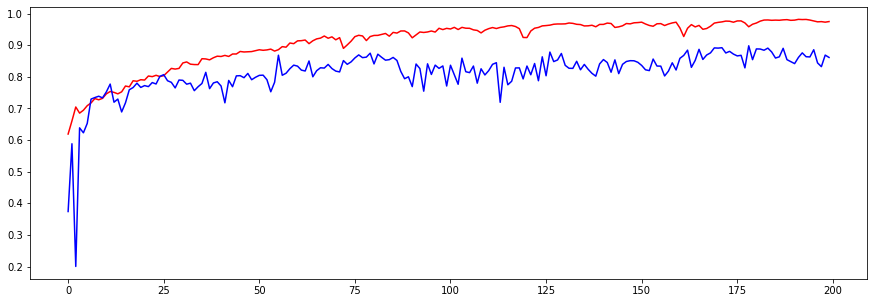

In [ ]:
import matplotlib.pyplot as plt
m_acc = history.history['accuracy']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(m_acc, color = 'r')
ax.plot(history.history['val_accuracy'], color = 'b')
# plt.legend()

In [ ]:
b_2model = tf.keras.models.load_model('best_model_n3.h5')
b_2model.evaluate(test_f, test_l)

98/98 [==============================] - 3s 25ms/step - loss: 0.3637 - accuracy: 0.8981


[0.3637402355670929, 0.8981095552444458]

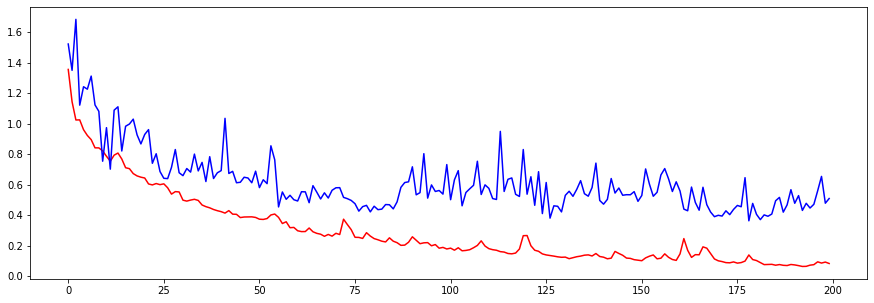

In [ ]:
loss = history.history['loss']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(loss, color = 'r')
ax.plot(history.history['val_loss'], color = 'b')

Model 2. Using Bidirectional LSTM

In [ ]:
# # adding globel average pooling to the model
# codding lstm layers and cnn
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,
                      input_shape=[128, 3]),
  tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(32), return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(32), return_sequences=True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  # tf.keras.layers.SpatialDropout1D(0.2),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # tf.keras.layers.Reshape((128,64,1)),
  # tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv1D(64,5,strides=2),
  tf.keras.layers.MaxPooling1D(2, strides = 2),
  tf.keras.layers.Dropout(.4),
  tf.keras.layers.Conv1D(128,3,strides=1),  
  # tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2)),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # parameters ?
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(6, activation='softmax')
  
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 128, 3)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128, 64)           9216      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128, 64)           24832     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 62, 64)            20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 31, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 29, 128)          

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
save = ModelCheckpoint('best_model_n3_bid.h5', save_best_only = True)

In [ ]:

optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

history = model.fit(train_windowed,validation_data=(test_f, test_l), epochs=200,callbacks=[save], verbose=1, batch_size=192) 

Epoch 1/200
74/74 [==============================] - 52s 661ms/step - loss: 1.3282 - accuracy: 0.6452 - val_loss: 1.6555 - val_accuracy: 0.4399
Epoch 2/200
74/74 [==============================] - 48s 649ms/step - loss: 1.0563 - accuracy: 0.6915 - val_loss: 1.1756 - val_accuracy: 0.6610
Epoch 3/200
74/74 [==============================] - 49s 655ms/step - loss: 0.9714 - accuracy: 0.7221 - val_loss: 1.6361 - val_accuracy: 0.6120
Epoch 4/200
74/74 [==============================] - 50s 673ms/step - loss: 0.8862 - accuracy: 0.7448 - val_loss: 1.3304 - val_accuracy: 0.6411
Epoch 5/200
74/74 [==============================] - 51s 686ms/step - loss: 0.8956 - accuracy: 0.7277 - val_loss: 1.0065 - val_accuracy: 0.7286
Epoch 6/200
74/74 [==============================] - 50s 670ms/step - loss: 0.8712 - accuracy: 0.7140 - val_loss: 0.9677 - val_accuracy: 0.6706
Epoch 7/200
74/74 [==============================] - 49s 668ms/step - loss: 0.8211 - accuracy: 0.7461 - val_loss: 0.9559 - val_accuracy:

In [ ]:
b_model = tf.keras.models.load_model('best_model_n3_bid.h5')

In [ ]:
b_model.evaluate(test_f, test_l)

98/98 [==============================] - 7s 62ms/step - loss: 0.3460 - accuracy: 0.9109


[0.3460378050804138, 0.9109259843826294]

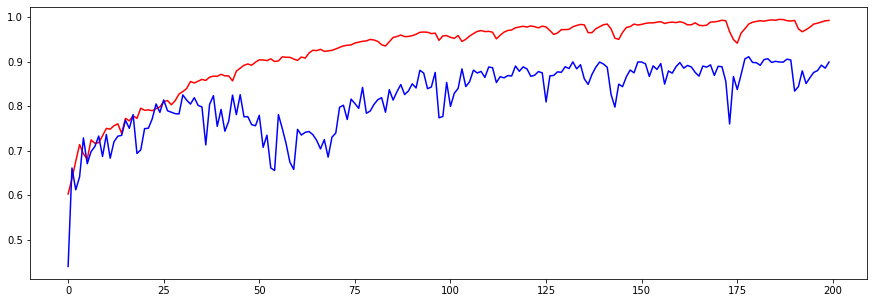

In [ ]:
import matplotlib.pyplot as plt
m_acc = history.history['accuracy']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(m_acc, color = 'r')
ax.plot(history.history['val_accuracy'], color = 'b')
# plt.legend()

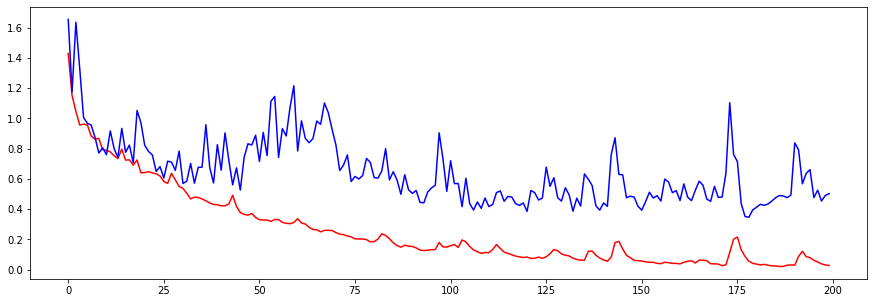

In [ ]:
loss = history.history['loss']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(loss, color = 'r')
ax.plot(history.history['val_loss'], color = 'b')

In [ ]:
# # adding globel average pooling to the model
# codding lstm layers and cnn
model_si_bi = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,
                      input_shape=[128, 3]),
  tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(32), return_sequences=True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(32), return_sequences=True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  # tf.keras.layers.SpatialDropout1D(0.2),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # tf.keras.layers.Reshape((128,64,1)),
  # tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv1D(64,5,strides=2),
  tf.keras.layers.MaxPooling1D(2, strides = 2),
  tf.keras.layers.Dropout(.4),
  tf.keras.layers.Conv1D(128,3,strides=1),  
  # tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2)),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # parameters ?
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(6, activation='softmax')
  
])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
save = ModelCheckpoint('best_model_n3_si_bid.h5', save_best_only = True)

In [ ]:

optimizer = tf.keras.optimizers.Adam(0.001)
model_si_bi.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

history = model_si_bi.fit(train_windowed,validation_data=(test_f, test_l), epochs=200,callbacks=[save], verbose=1, batch_size=192) 

Epoch 1/200
74/74 [==============================] - 29s 363ms/step - loss: 1.3949 - accuracy: 0.6159 - val_loss: 1.5978 - val_accuracy: 0.3896
Epoch 2/200
74/74 [==============================] - 26s 351ms/step - loss: 1.0974 - accuracy: 0.6630 - val_loss: 1.3275 - val_accuracy: 0.5066
Epoch 3/200
74/74 [==============================] - 26s 351ms/step - loss: 0.9711 - accuracy: 0.6971 - val_loss: 1.1323 - val_accuracy: 0.6389
Epoch 4/200
74/74 [==============================] - 26s 354ms/step - loss: 0.9380 - accuracy: 0.6979 - val_loss: 1.0820 - val_accuracy: 0.6562
Epoch 5/200
74/74 [==============================] - 26s 357ms/step - loss: 0.8956 - accuracy: 0.7152 - val_loss: 0.9780 - val_accuracy: 0.7200
Epoch 6/200
74/74 [==============================] - 26s 354ms/step - loss: 0.8511 - accuracy: 0.7240 - val_loss: 1.0051 - val_accuracy: 0.7139
Epoch 7/200
74/74 [==============================] - 27s 360ms/step - loss: 0.8292 - accuracy: 0.7367 - val_loss: 1.0540 - val_accuracy: